# Next Sentence Prediction using BERT

In this implementation, we will be using the Quora Insincere question dataset in which we have some question which may contain profanity, foul-language hatred, etc. We will be using BERT from TF-dev.



In [1]:
# Clone the TensorFlow models Repo
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 505), reused 1389 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 2.89 MiB/s, done.
Resolving deltas: 100% (505/505), done.
Note: switching to '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [1]:
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

# keras imports
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

# Load the Quora Insincrere QUesrtion dataset
df = pd.read_csv(
  'https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', compression='zip')
df.head()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


<Axes: title={'center': 'Sincere (0) vs Insincere (1) distribution'}, ylabel='Frequency'>

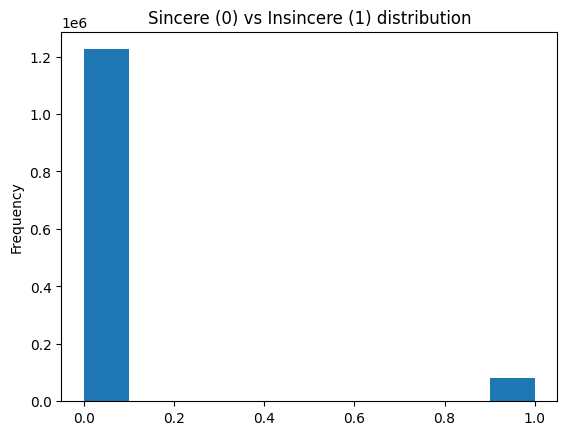

In [2]:
df.target.plot(kind='hist', title='Sincere (0) vs Insincere (1) distribution')

In [3]:
from sklearn.model_selection import train_test_split

# split into train and validation
train_df, remaining = train_test_split(df, train_size=0.01, stratify=df.target.values)

valid_df, _ = train_test_split(remaining, train_size=0.001, stratify=remaining.target.values)
train_df.shape, valid_df.shape

((13061, 3), (1293, 3))

In [4]:
# import for processing dataset
from tensorflow.data.experimental import AUTOTUNE

# convert dataset into tensor slices
train_data = tf.data.Dataset.from_tensor_slices((train_df.question_text.values, train_df.target.values))
valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

for text, label in train_data.take(2):
  print("Text", text)
  print("Label", label)

Text tf.Tensor(b'What is mala fide?', shape=(), dtype=string)
Label tf.Tensor(0, shape=(), dtype=int64)
Text tf.Tensor(b'What is the use of system software?', shape=(), dtype=string)
Label tf.Tensor(0, shape=(), dtype=int64)


In [5]:
label_list = [0, 1] # Label categories
max_seq_length = 128 # maximum length of input sequences
train_batch_size = 32

# Get BERT layer and tokenizer
bert_layer = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True
)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [6]:
# example
# convert to tokens ids and
tokenizer.convert_tokens_to_ids(
    tokenizer.wordpiece_tokenizer.tokenize('how are you?')
)

[2129, 2024, 2017, 29632]

In [7]:
# convert the dataset into the format required by BERT i.e we convert the row into
# input features (Token id, input mask, input type id ) and labels
def convert_to_bert_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [8]:
# wrap the dataset around the python function in order to use the tf
# datasets map function
def to_bert_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(
      convert_to_bert_feature,
      inp=[text, label],
      Tout=[tf.int32, tf.int32, tf.int32, tf.int32]
  )

  # py_func doesn't set the shape of the returned tensors
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_word_ids': input_ids,
      'input_mask': input_mask,
      'input_type_ids': segment_ids
  }

  return (x, label_id)

In [9]:
train_data = train_data.map(to_bert_feature_map, num_parallel_calls=AUTOTUNE) \
                       .shuffle(1000) \
                       .batch(32, drop_remainder=True) \
                       .prefetch(AUTOTUNE)

valid_data = valid_data.map(to_bert_feature_map, num_parallel_calls=AUTOTUNE) \
                       .batch(32, drop_remainder=True) \
                       .prefetch(AUTOTUNE)

# example format train and valid data
print("Train data format: ", train_data.element_spec)
print("Validation data format: ", valid_data.element_spec)

Train data format:  ({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None), 'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(32,), dtype=tf.int32, name=None))
Validation data format:  ({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None), 'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(32,), dtype=tf.int32, name=None))


In [10]:
# define the keras model
# Building the model
def fine_tuned_model():
  input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
  input_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  input_type_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = Dropout(0.4)(pooled_output)

  output = Dense(1, activation="sigmoid", name="output")(drop)

  model = Model(
      inputs={
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs=output
  )
  return model

In [11]:
# compile the model
model = fine_tuned_model()
model.compile(optimizer=Adam(learning_rate=2e-5),
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                              

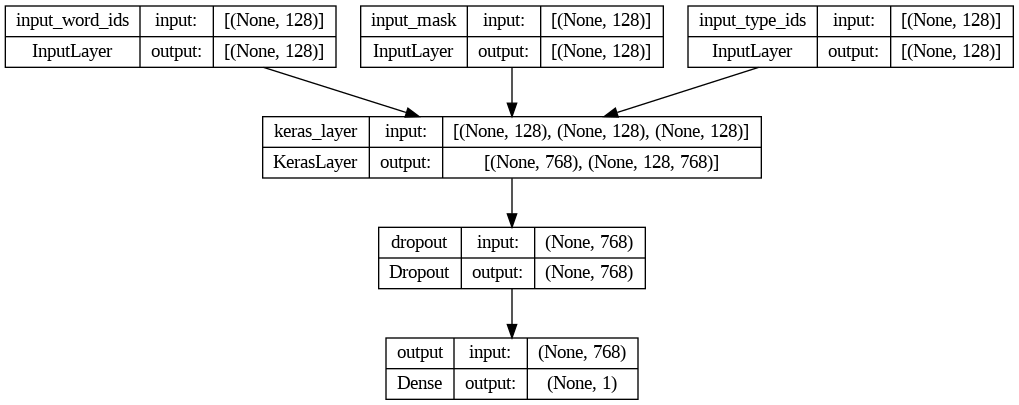

In [12]:
# plot the model
plot_model(model=model, show_shapes=True)

In [13]:
# Train model
epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/4
408/408 [==============================] - 350s 816ms/step - loss: 0.1561 - binary_accuracy: 0.9417 - val_loss: 0.1162 - val_binary_accuracy: 0.9523
Epoch 2/4
408/408 [==============================] - 357s 873ms/step - loss: 0.0939 - binary_accuracy: 0.9645 - val_loss: 0.1298 - val_binary_accuracy: 0.9547
Epoch 3/4
408/408 [==============================] - 342s 836ms/step - loss: 0.0488 - binary_accuracy: 0.9831 - val_loss: 0.1767 - val_binary_accuracy: 0.9516
Epoch 4/4
408/408 [==============================] - 359s 877ms/step - loss: 0.0235 - binary_accuracy: 0.9925 - val_loss: 0.2764 - val_binary_accuracy: 0.9461


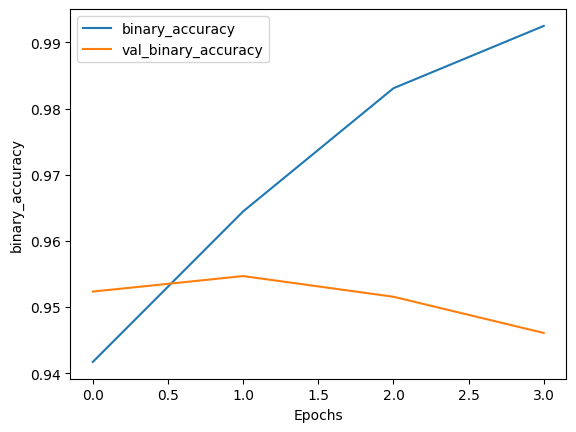

In [14]:
import matplotlib.pyplot as plt

# plot the accuracy
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
plot_graphs(history, 'binary_accuracy')

In [15]:
# check
test_eg=['what is the current marketprice of petroleum?',
		'who is Oswald?', 'why are you here idiot ?']
test_data =tf.data.Dataset.from_tensor_slices((test_eg, [0]*len(test_eg)))
# wrap test data into BERT format
test_data = (test_data.map(to_bert_feature_map).batch(1))
preds = model.predict(test_data)
print(preds)
['Insincere' if pred >=0.5 else 'Sincere' for pred in preds]

3/3 [==============================] - 1s 24ms/step
[[1.3666249e-04]
 [3.5433852e-05]
 [8.5245353e-01]]


['Sincere', 'Sincere', 'Insincere']

---